In [ ]:
from __future__ import division
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np, pickle
import math, sys, os, glob, h5py, json
from astropy import units as u
from sklearn.neighbors import KernelDensity

import pint
from pint import toa
from pint import models
from pint.residuals import Residuals
from pint.simulation import make_fake_toas_fromMJDs
pint.logging.setup(sink=sys.stderr, level="WARNING", usecolors=True)

import pta_replicator
from pta_replicator import simulate
from pta_replicator import white_noise

WARNING  (pint.logging                  ): /opt/homebrew/Caskroom/mambaforge/base/envs/sarahspta/lib/python3.12/site-packages/enterprise/signals/utils.py:13 UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
libstempo not installed. PINT or libstempo are required to use par and tim files.


WARNING  (pint.logging                  ): /opt/homebrew/Caskroom/mambaforge/base/envs/sarahspta/lib/python3.12/site-packages/pint/models/stand_alone_psr_binaries/DDK_model.py:146 UserWarning: DDK model uses KIN as inclination angle. SINI will not be used. This happens every time a DDK model is constructed.
WARNING  (pint.models.noise_model       ): Log-spaced parameters are ignored because logmode, nlog, and f_min ALL neeed to be setUse: logmode > 0 and nlog > 0 and f_min > 0.
WARNING  (pint.logging                  ): /opt/homebrew/Caskroom/mambaforge/base/envs/sarahspta/lib/python3.12/site-packages/pint/models/noise_model.py:216 UserWarning: EQUAD maskParameter(EQUAD2 -f 3GHz_YUPPI 0.3034141527468192 (us) frozen=True) has no TOAs
WARNING  (pint.logging                  ): /opt/homebrew/Caskroom/mambaforge/base/envs/sarahspta/lib/python3.12/site-packages/pint/models/noise_model.py:216 UserWarning: EQUAD maskParameter(EQUAD3 -f CHIME 6.812699107771819 (us) frozen=True) has no TOAs
WAR

In [2]:
# datadir = '/Users/vigeland/Documents/Research/NANOGrav/nanograv_data/NG20/Data/ng20_v1p1_dmx/'

# myparfile = datadir + 'parfiles/J1909-3744_PINT_20250319.nb.par'
# mytimfile = datadir + 'timfiles/J1909-3744_PINT_20250411.nb.tim'

#my paths'
mypardir = '/Users/ashokan/osu/sarahspta/ng20/results/'
mytimdir = '/Users/ashokan/osu/sarahspta/NG20_prelim_v1p0_excised_toas/'
#myparfile = mypardir + 'J1909-3744_PINT_20250319.nb.par'
#mytimfile = mytimdir + 'J1909-3744_PINT_20250411.nb.tim'

myparfile = mypardir + 'J1713+0747_PINT_20250429.nb.par'
mytimfile = mytimdir + 'J1713+0747_PINT_20250411.nb.tim'

psr = simulate.load_pulsar(myparfile, mytimfile, ephem='DE440')

In [3]:
# remove red noise from the model (we will add it back later)
if 'PLRedNoise' in psr.model.components.keys():
    psr.model.remove_component('PLRedNoise')
    
psr.generate_daily_avg_toas(ideal=True)

Pulsar J1713+0747 has 68448 TOAs observed with 13 systems...
Filtering out 1522 TOAs with flag 1.5GHz_YUPPI observed with vla...
Filtering out 3492 TOAs with flag 3GHz_YUPPI observed with vla...
Filtering out 3653 TOAs with flag CHIME observed with chime...
Filtering out 864 TOAs with flag L-wide_ASP observed with arecibo...
Filtering out 13270 TOAs with flag L-wide_PUPPI observed with arecibo...
Filtering out 1109 TOAs with flag Rcvr1_2_GASP observed with gbt...
Filtering out 22536 TOAs with flag Rcvr1_2_GUPPI observed with gbt...
Filtering out 3133 TOAs with flag Rcvr1_2_VEGAS observed with gbt...
Filtering out 1037 TOAs with flag Rcvr_800_GASP observed with gbt...
Filtering out 8544 TOAs with flag Rcvr_800_GUPPI observed with gbt...
Filtering out 1091 TOAs with flag Rcvr_800_VEGAS observed with gbt...
Filtering out 635 TOAs with flag S-wide_ASP observed with arecibo...
Filtering out 7562 TOAs with flag S-wide_PUPPI observed with arecibo...
Pulsar J1713+0747 now has 1507 daily averag

In [4]:
def get_current_flags(flags):
    
    current_backends = ['CHIME', 'YUPPI', 'VEGAS']
    current_flags = []
    
    for f in flags:
        if np.any([c in f for c in current_backends]):
            current_flags.append(f)
    
    return current_flags

def get_cadence(toas, flag, dt=365):
    
    obs = toas[toas['f'] == f].get_mjds().to(u.d).value
    
    last_obs = max(obs)
    nobs = len(np.where(obs >= max(obs) - 365)[0])
    
    return nobs

In [5]:
def get_errors(psr, flag, numobs):

    log10_errs = np.log10(psr.toas[psr.toas['f'] == flag].get_errors().to(u.s).value)
    
    # fit KDE to distribution of the log10_errs
    # only fit to the distribution up to the 95% upper limit to avoid drawing extremely large errors
    log10_err_distr = log10_errs[log10_errs < np.percentile(log10_errs, 95)]
    mykde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(log10_err_distr.reshape((log10_err_distr.size, 1)))
    errs = 10**mykde.sample(numobs).reshape(numobs)
    
    return errs

def make_new_toas(psr, flag, cadence, end_mjd):
    
    if 'VEGAS' in flag:
        obs = 'gbt'
    elif 'CHIME' in flag:
        obs = 'chime'
    elif 'YUPPI' in flag:
        obs = 'vla'
    
    last_obs = max(psr.toas[psr.toas['f'] == flag].get_mjds().to(u.d).value)
    
    Tspan = end_mjd - last_obs
    nobs = int(Tspan/365.24*cadence)
    delta_t = 365.24/cadence

    start_mjd = last_obs + delta_t

    mjds = np.arange(start_mjd, end_mjd, delta_t)

    errs = get_errors(psr, flag, nobs)

    return toa.get_TOAs_array(mjds, obs=obs, flags={'f': flag}, model=None, 
                              errors=errs*1e6, planets=True, ephem='DE440')

In [6]:
end_mjd = 61587

flags = list(np.unique(psr.toas['f']))
current_flags = get_current_flags(flags)

if len(current_flags) < 1:
    print('This pulsar is not currently being observed!')

else:
    for f in current_flags:

        print('Making new observations with {0}...'.format(f))
        cadence = get_cadence(psr.toas, f)
        
        if cadence == 0:
            print('This pulsar is not currently being observed with {0}.'.format(f))
            
        else:
            new_toas = make_new_toas(psr, f, cadence, end_mjd)

            # make sure the new TOAs are compatible with the old ones
            if psr.toas.obliquity is not None:
                new_toas.obliquity = psr.toas.obliquity
                new_toas.update_all_times()
    
            if 'fe' in psr.toas.table.keys():
                new_toas.table.add_column([None for _ in range(len(new_toas))], name='fe')
        
            if 'f' in psr.toas.table.keys():
                new_toas.table.add_column([f for _ in range(len(new_toas))], name='f')
    
            psr.toas.merge(new_toas)

Making new observations with 1.5GHz_YUPPI...
Making new observations with 3GHz_YUPPI...
Making new observations with CHIME...
Making new observations with Rcvr1_2_VEGAS...
Making new observations with Rcvr_800_VEGAS...


In [7]:
simulate.make_ideal(psr)

white_noise.add_measurement_noise(psr, efac=1)

for _ in range(3):
    psr.fit()
    
# at this point, you could also inject in red noise and a GWB

StepProblem: Unable to improve chi2 even with very small steps

In [10]:
white_noise.add_measurement_noise??

Signature:
white_noise.add_measurement_noise(
    psr: pta_replicator.simulate.SimulatedPulsar,
    efac: float = 1.0,
    log10_equad: float = None,
    flagid: str = 'f',
    flags: list = None,
    seed: int = None,
    tnequad: bool = False,
)
Source:   
def add_measurement_noise(psr: SimulatedPulsar, efac: float = 1.0,
                          log10_equad: float = None,
                          flagid: str = 'f', flags: list = None,
                          seed: int = None, tnequad: bool = False):
    """
    Add nominal TOA errors added by EQUAD, and then multiplied by an EFAC factor.
    Optionally take a pseudorandom-number-generator seed.

    Parameters
    ----------
    psr : SimulatedPulsar
        The pulsar to add noise to.
    efac : float or list
        The multiplicative factor for the TOA errors.
    log10_equad : float or list
        The additive factor for the TOA errors measured in log10(seconds).
    flagid : str
        The key for the flags in the TOA tab

In [8]:
def make_residual_plot(psr, save=False, simdir='pint_sims1/'):

    # switch to rainbow colormap grouped by telescopes
    colors = {
                "CHIME": "#FFA733",
                "327_ASP": "#BE0119",
                "327_PUPPI": "#BE0119",
                "430_ASP": "#FD9927",
                "430_PUPPI": "#FD9927",
                "L-wide_ASP": "#BDB6F6",
                "L-wide_PUPPI": "#BDB6F6",
                "Rcvr1_2_GASP": "#79A3E2",
                "Rcvr1_2_GUPPI": "#79A3E2",
                "Rcvr1_2_VEGAS": "#79A3E2",
                "Rcvr_800_GASP": "#8DD883",
                "Rcvr_800_GUPPI": "#8DD883",
                "Rcvr_800_VEGAS": "#8DD883",
                "S-wide_ASP": "#C4457A",
                "S-wide_PUPPI": "#C4457A",
                "1.5GHz_YUPPI": "#EBADCB",
                "3GHz_YUPPI": "#E79CC1",
                "6GHz_YUPPI": "#DB6BA1",
            }

    fig, axs = plt.subplots(1, 1)

    flags = list(np.unique(psr.toas['f']))

    for f in flags:

        idx = (psr.toas['f'] == f)
    
        axs.errorbar(psr.toas[idx].get_mjds(), psr.residuals.calc_time_resids()[idx], 
                     yerr=psr.toas[idx].get_errors(), marker='.', ls='', alpha=0.5, 
                     label=f, color=colors[f])

    plt.title('{0} -- {1} TOAs'.format(psr.name, len(psr.toas)))
    plt.xlabel('MJD')
    plt.ylabel('Residual [s]')
    plt.legend()
    plt.tight_layout();

    if save:
        plt.savefig(simdir + '/{0}.png'.format(psr.name))

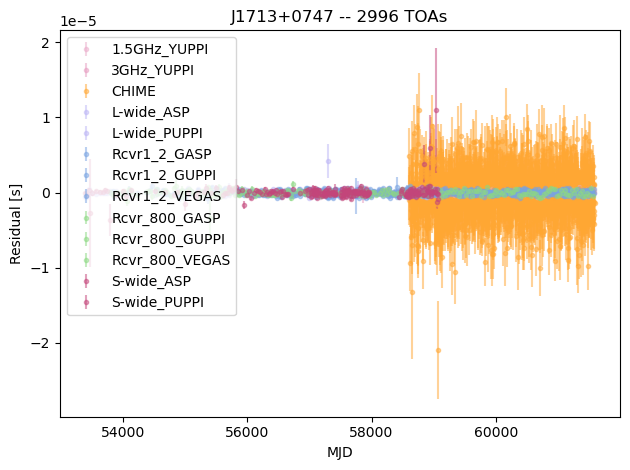

In [9]:
make_residual_plot(psr, save=False)